<a href="https://colab.research.google.com/github/MasaAsami/monitoring_for_COVID19_vaccine_intake_rate/blob/main/notebooks/monitoring_for_COVID19_vaccine_intake_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 都道府県別ワクチン摂取完了率と新規感染者数の監視ノート
## とっても大切な注意事項
- 本ノートの著者は医療関係者ではありません（ど素人です）
- 単純に公開情報を可視化して眺めるだけ＋α
- 本ノートを更新する場合は、データ元に負荷をかけないように気をつけましょう（スクレイピング）

In [1]:
!pip install -q  japanize_matplotlib

In [2]:
#@title Pythonモジュールをimport { display-mode: "form" }

import warnings

warnings.filterwarnings("ignore")

from IPython.display import display, HTML
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

plt.style.use("ggplot")

In [3]:
%matplotlib inline

## (1) データ取得
- 下記のデータを使用
- 当該notebookを更新する場合は、連打しないように気をつけましょう

### 都道府県ごとの摂取率：

- 政府CIOポータル [新型コロナワクチンの接種状況](https://cio.go.jp/c19vaccine_dashboard) (デジタル庁)

### 直近１週間の感染者数：

 - NHK [特設サイト新型コロナウイルス](https://www3.nhk.or.jp/news/special/coronavirus/data/)

In [4]:
#@title データ取得 from 新型コロナワクチンの接種状況 (デジタル庁)  { display-mode: "form" }
INTALE_RATE_URL = "https://info.vrs.digital.go.jp/dashboard/"

_dfs = pd.read_html(INTALE_RATE_URL)

vaccine_intake_rate = (
    _dfs[1]
    .rename(
        columns={
            "都道府県": "prefectures",
            "1回目接種率": "first_vaccine_completion_rate",
            "2回目接種率": "second_vaccine_completion_rate",
            "3回目接種率": "third_vaccine_completion_rate",
            "4回目接種率": "fourth_vaccine_completion_rate",
        }
    )
    .apply(lambda x: x.str.replace("%", ""))
)

In [5]:
# @title データ取得 from 特設サイト新型コロナウイルス (NHK)  { display-mode: "form" } 

NHK_URL = (
    "https://www3.nhk.or.jp"
    + "/n-data/opendata/coronavirus/nhk_news_covid19_prefectures_daily_data.csv"
)

infections_cnt_df = (
    pd.read_csv(NHK_URL)
    .rename(
        columns={
            "都道府県名": "prefectures",
            "日付": "dt",
            "各地の直近1週間の人口10万人あたりの感染者数": "infections_cnt_in_the_last_week",
        }
    )[["dt", "prefectures", "infections_cnt_in_the_last_week"]]
)

last_dt = infections_cnt_df["dt"].max()
infections_cnt_df = infections_cnt_df.query("dt ==@last_dt").set_index('dt')

assert len(infections_cnt_df) == len(vaccine_intake_rate), "[assertion error] 件数が一致しません"

In [6]:
merged_df = (
    pd.merge(infections_cnt_df, vaccine_intake_rate, on="prefectures", how="left")
    .set_index("prefectures")
    .astype(float)
)

assert len(merged_df) == len(infections_cnt_df), "[assertion error] 件数が一致しません"

merged_df.sample(5)

,infections_cnt_in_the_last_week,first_vaccine_completion_rate,second_vaccine_completion_rate,third_vaccine_completion_rate,fourth_vaccine_completion_rate
prefectures,,,,,
広島県,1030.18,74.08,73.60,61.41,14.66
滋賀県,1202.31,77.32,76.79,62.43,13.62
山口県,924.03,75.45,75.02,66.98,17.51
静岡県,1105.75,80.93,80.38,65.74,14.18
岐阜県,1133.04,77.75,77.35,65.98,18.48


## (2) 単純集計
- 細かいことは考えずに、まずはデータを俯瞰してみる

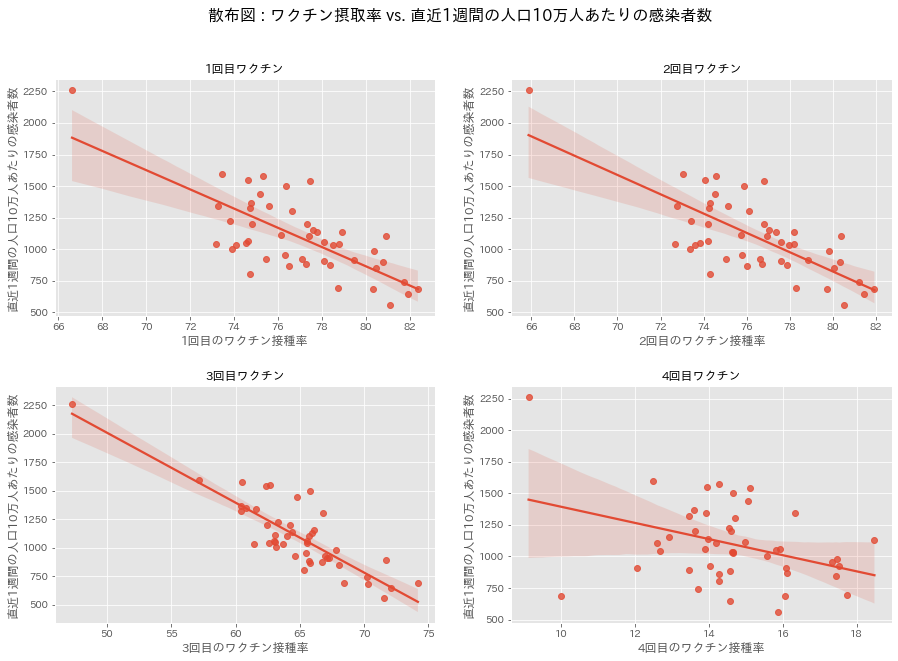

In [7]:
# @title 散布図 ワクチン摂取率 vs. 直近1週間の人口10万人あたりの感染者数 { display-mode: "form" }
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.3)
ax = [item for sublist in ax for item in sublist]  
treatmemt_list = [
    "first_vaccine_completion_rate",
    "second_vaccine_completion_rate",
    "third_vaccine_completion_rate",
    "fourth_vaccine_completion_rate",
]

for i, _step in enumerate(treatmemt_list):
    ax[i].set_ylabel("直近1週間の人口10万人あたりの感染者数", fontsize=12)
    ax[i].set_title(f"{i+1}回目ワクチン", fontsize=12)
    
    sns.regplot(x=_step, y="infections_cnt_in_the_last_week", data=merged_df, ax=ax[i])
    ax[i].set_ylabel("直近1週間の人口10万人あたりの感染者数", fontsize=12)
    ax[i].set_xlabel(f"{i+1}回目のワクチン接種率", fontsize=12)

fig.suptitle("散布図 : ワクチン摂取率 vs. 直近1週間の人口10万人あたりの感染者数", fontsize=16)
plt.show()

## (3) 超〜雑分析

In [8]:
naive_regression = sm.OLS(
    merged_df["infections_cnt_in_the_last_week"],
    sm.add_constant(merged_df["third_vaccine_completion_rate"]),
).fit()

print("共変量がないと仮定したときのワクチン効果 : ", naive_regression.params[1])
print("  ※ 単位に注意")
naive_regression.summary().tables[1]

共変量がないと仮定したときのワクチン効果 :  -61.4067088299703
  ※ 単位に注意


,coef,std err,t,P>|t|,[0.025,0.975]
const,5080.2294,374.342,13.571,0.000,4326.266,5834.193
third_vaccine_completion_rate,-61.4067,5.761,-10.659,0.000,-73.010,-49.804


## (4) ありえるツッコミと対応
### ツッコミ
- ワクチン摂取と感染は、COVID-19に対する意識(U)の違いがある
    - U -> ワクチン摂取 : ポジティブ
    - U -> 感染率 : ネガティブ
- が直感的に想定され、効果が過大評価されているのではないか

### 対応方針
- COVID-19に対する意識(U)の代替変数的なもの探してくる(年齢とか) => めんどくさいのでプロに任せる
- 自然実験的な工夫でLATEを見れないか探索 => めんどくさいからプロに任せる
- COVID-19に対する意識(U)の影響を保守的に見積もって、それでもワクチン摂取効果の符号が維持できることを示す (※感度分析)


### 感度分析 （Sensitivity Analysis） is 何？

#### 伝統的な感度分析 
[便宜的定義]

- T を介入変数 : 3回目ワクチン摂取率
- Y をアウトカム：感染率
- Wは観測可能な共変量：このnotebookではなし
- Uは未観測な共変量：COVID-19に対する意識とか

$$
T := \alpha _w W + \alpha _u U 
$$

 $$
Y :=  \beta _w W +  \beta _u U +  \delta T
$$

このような世界観で、Uを観察できない時のバイアスは$ \frac{ \beta _u}{ \alpha _u} $ である

$$
    E_w[E[Y|T=1, W] - E[Y|T=0, W]] -  E_{w, u}[E[Y|T=1, W, U] - E[Y|T=0, W, U]] =  \frac{ \beta _u}{ \alpha _u} 
$$

(see ; Introduction to Causal Inference https://www.bradyneal.com/causal-inference-course )

つまり、$\alpha _u$(未捕捉共変量がワクチン摂取に与える影響) と $ \beta _u$ （未捕捉共変量がアウトカムに与える影響）を見積もれば、バイアスの程度がわかる。
（＝どの程度の$\alpha _u$と $ \beta _u$であれば、観察されている効果の符号を逆転させるほどのバイアスになるのか、その見積もりは現実的にありそうか議論できる）

####  Cinelli and Hazlett (2020)
- 上記の例は、変数のオーダーがあってないと使いにくい（標準化するればいいけど、めんどくさい）
- あと、未観測の共変量が複数の場合に一般化する必要がある
- 以下では、Cinelli and Hazlett (2020)及びそのRパッケージで[`sensemakr`](https://cran.r-project.org/web/packages/sensemakr/vignettes/sensemakr.html)で遊んでみる<br>
<br>
Cinelli C, Hazlett C (2020a). “Making Sense of Sensitivity: Extending Omitted Variable
Bias.” Journal of the Royal Statistical Society: Series B (Statistical Methodology), 82(1),
39–67. doi:10.1111/rssb.12348.


In [9]:
# @title R言語の立ち上げ、データをR言語に渡す
%load_ext rpy2.ipython

%R -i merged_df

In [10]:
%%R 
install.packages("sensemakr")
library(sensemakr)


naive_model <- lm(infections_cnt_in_the_last_week ~ third_vaccine_completion_rate, data = merged_df)

model_sensitivity <- sensemakr(
    model = naive_model, 
    treatment = "third_vaccine_completion_rate",
    q = 1,
    alpha = 0.05, 
    reduce = TRUE
)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpmN2dzq/downloaded_packages’





In [11]:
%%R 
model_sensitivity

Sensitivity Analysis to Unobserved Confounding

Model Formula: infections_cnt_in_the_last_week ~ third_vaccine_completion_rate

Null hypothesis: q = 1 and reduce = TRUE 

Unadjusted Estimates of ' third_vaccine_completion_rate ':
  Coef. estimate: -61.40671 
  Standard Error: 5.76097 
  t-value: -10.65908 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.7163 
  Robustness Value, q = 1 : 0.767 
  Robustness Value, q = 1 alpha = 0.05 : 0.70179 

For more information, check summary.

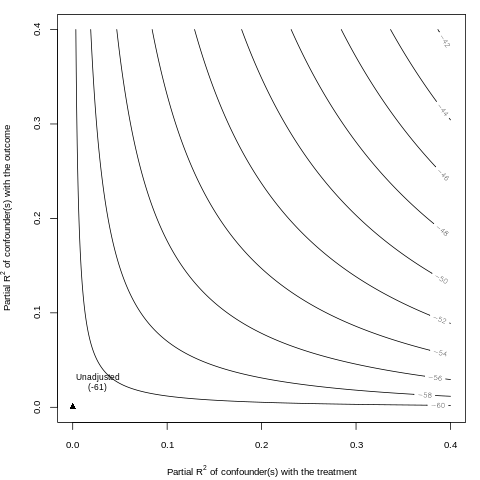

In [12]:
%%R
plot(model_sensitivity)

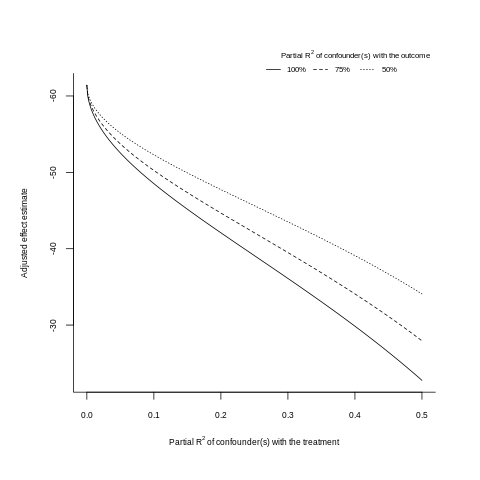

In [13]:
%%R
plot(model_sensitivity, type = "extreme")

In [14]:
%%R 
html_report <- ovb_minimal_reporting(model_sensitivity, format = "html")

<table>
<thead>
<tr>
	<th style="text-align:left;border-bottom: 1px solid transparent;border-top: 1px solid black"> </th>
	<th colspan = 6 style="text-align:center;border-bottom: 1px solid black;border-top: 1px solid black"> Outcome: infections_cnt_in_the_last_week</th>
</tr>
<tr>
	<th style="text-align:left;border-top: 1px solid black"> Treatment </th>
	<th style="text-align:right;border-top: 1px solid black"> Est. </th>
	<th style="text-align:right;border-top: 1px solid black"> S.E. </th>
	<th style="text-align:right;border-top: 1px solid black"> t-value </th>
	<th style="text-align:right;border-top: 1px solid black"> $R^2_{Y \sim D |{\bf X}}$ </th>
	<th style="text-align:right;border-top: 1px solid black">  $RV_{q = 1}$ </th>
	<th style="text-align:right;border-top: 1px solid black"> $RV_{q = 1, \alpha = 0.05}$ </th>
</tr>
</thead>
<tbody>
 <tr>
	<td style="text-align:left; border-bottom: 1px solid black"><i>third_vaccine_completion_rate</i></td>
	<td style="text-align:right;border-

In [15]:
%R -o html_report
display(HTML(html_report[0]) )

In [16]:
print("Done!")
print("TODO これをPythonに書き換える")

Done!
TODO これをPythonに書き換える
